In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import xgboost

from functions import make_dataset

from functions import make_portfolio

from sklearn.utils import shuffle

import time

import pickle

In [2]:
features2 = pd.read_pickle("training_sets/features2")
Date2 = np.load("training_sets/Date2.npy", allow_pickle = True)


In [3]:
cols = np.random.choice(features2.columns[:-3], 15)

In [4]:
cols

array(['ABAND_indicator_20',
       'Total Current Liabilities/Total Liabilities_YC',
       'Net Income/Enterprise Value', 'AROON_80', 'close_10/Close_320',
       'Share Capital & Additional Paid-In Capital_YC',
       'Enterprise Value/Share Capital & Additional Paid-In Capital',
       'Net Income_QC', 'Cash & Cash Equivalents', 'close_160/Close_240',
       'Net Income', 'Book to Market Value', 'Return on Equity',
       'Total Assets_QC', 'volstd_80'], dtype=object)

In [5]:
def make_dataset_eval_with_extra_return_40_term_from_periods(df, training_period, prediction_period, cols, pred_col):
    
    
    X_train = shuffle(df.loc[training_period, np.append(cols, pred_col)])
    X_train = X_train.replace([np.inf, -np.inf], np.NaN)
    X_train = X_train.dropna(axis = 0)

    Y_train = X_train.pop(pred_col)

    
    X_test = shuffle(df.loc[prediction_period, np.append(np.append(cols, pred_col), "return_40")])
    X_test = X_test.replace([np.inf, -np.inf], np.NaN)
    X_test = X_test.dropna(axis = 0)
    
    Y_test = X_test.pop(pred_col)
    Y_return_40 = X_test.pop("return_40")
    
    return X_train, X_test, Y_train, Y_test, Y_return_40

In [55]:
def return_40_metric(pred, labels):


    return np.mean(labels[np.argsort(pred[:,0])[::-1][:500]]), np.sort(pred[:,0])[::-1][499], np.mean(labels[np.argsort(pred[:,0])[::-1][:100]]), np.sort(pred[:,0])[::-1][99], np.mean(labels[np.argsort(pred[:,0])[::-1][:20]]), np.sort(pred[:,0])[::-1][19]

In [34]:
np.argsort(predt)

array([15749, 16052,  7520, ..., 10375, 15711, 31798], dtype=int64)

In [54]:
def return_40_metric2(pred, labels):


    return np.mean(labels[np.argsort(pred)[:500]]), (1-np.sort(pred)[499]), np.mean(labels[np.argsort(pred)[:100]]), (1-np.sort(pred)[99]), np.mean(labels[np.argsort(pred)[:20]]), (1-np.sort(pred)[19])

In [62]:
class my_callback(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            
            
       # if not epoch %10:

          #  print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [63]:
class my_callback2(xgboost.callback.TrainingCallback):
    
    def __init__(self, xgeval, Y_eval_return_40, results_eval):
        self.eval_mine = xgeval
        self.eval_return_40 = Y_eval_return_40
        self.results_eval_mine = results_eval
        
        
    def after_iteration(self, model, epoch, evals_log):
            
            
        #if not epoch %10:

          #  print(epoch)

        predictions_eval = model.predict(self.eval_mine)

        self.results_eval_mine.append(return_40_metric2(model.predict(self.eval_mine), self.eval_return_40))    
        
                 
            
        return False

In [58]:
params1 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'multi:softprob',
  'subsample': 0.9,
'num_class' : 2,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [59]:
params2 = {
  'colsample_bynode': 0.6,
    'colsample_bytree' : 0.6,
    'colsample_bylevel' : 0.5,
  'learning_rate': 0.3,
  'max_depth': 3,
  'num_parallel_tree': 100,
  'objective': 'binary:logistic',
  'subsample': 0.9,
  'tree_method': 'gpu_hist',
    "verbosity" : 0,
    "lambda" : 1,
    "alpha" : 0
}

In [9]:
prediction_date_number = 500

In [11]:
training_period = Date2[prediction_date_number - 200 - 40 + 1: prediction_date_number - 40 +1]

prediction_period = Date2[prediction_date_number :prediction_date_number + 20 + 1]

In [12]:
X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(features2, training_period, prediction_period, cols, "Class_binary_40_20")

In [28]:
train_weights = Y_train.map({0:19, 1:1})
xgtrain = xgboost.DMatrix(X_train.values, Y_train, feature_names = cols)
xgtest = xgboost.DMatrix(X_test.values, Y_test.values, feature_names = cols)

In [49]:
len(Date2)

786

In [60]:
cols_trials = []
for i in range(20):
    cols_trials.append(np.random.choice(features2.columns[:-3], 18, replace = False))

In [113]:
cols_trials

[array(['Net Cash from Operating Activities/Cash & Cash Equivalents_QC',
        'RSI_28', 'close_10/Close_320', 'ATR_10', 'Revenue_QC',
        'ULTOSC_28', 'close_40/Close_240', 'volatility_320', 'OBV_40',
        'EV/Sales', 'volatility_80', 'Price to Book Value',
        'Operating Income (Loss)/Interest Expense, Net_YC', 'OBV_160',
        'ABAND_indicator_40', 'volstd_360', 'APO_10_40', 'EBITDA_QC'],
       dtype=object),
 array(['ABAND_indicator_80', 'Shares (Diluted)/Shares (Basic)_YC',
        'WillR_10', 'Share Capital & Additional Paid-In Capital',
        'ULTOSC_28', 'ATR_160', 'close_0/Close_40',
        'Property, Plant & Equipment, Net_QC', 'volatility_160',
        'Cost of Revenue', 'Net Income/Enterprise Value',
        'Net Profit Margin_QC', 'Payables & Accruals/Cost of Revenue_QC',
        'volstd_360', 'Net Income/Enterprise Value_QC', 'ADX_1_5', 'RSI_7',
        'ADX_1_11'], dtype=object),
 array(['volstd_20', 'ABAND_indicator_20',
        'Property, Plant & Equ

In [61]:
prediction_dates = np.linspace(220, 700, 15).astype(int)

In [114]:
prediction_dates

array([220, 254, 288, 322, 357, 391, 425, 460, 494, 528, 562, 597, 631,
       665, 700])

In [64]:
results = []
for prediction_date_number in prediction_dates:
    for cols in cols_trials:
        
        training_period = Date2[prediction_date_number - 200 - 40 + 1: prediction_date_number - 40 +1]

        prediction_period = Date2[prediction_date_number :prediction_date_number + 20 + 1]
        
        X_train, X_test, Y_train, Y_test, Y_return_40 = make_dataset_eval_with_extra_return_40_term_from_periods(features2, training_period, prediction_period, cols, "Class_binary_40_20")
        
        train_weights = Y_train.map({0:19, 1:1})
        xgtrain = xgboost.DMatrix(X_train.values, Y_train, feature_names = cols)
        xgtest = xgboost.DMatrix(X_test.values, Y_test.values, feature_names = cols)
        
        data = []
        
        mycallback = my_callback(xgtest, Y_return_40, data)

        start_time = time.perf_counter()
        bst = xgboost.train(params1, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback])
        print(time.perf_counter() - start_time)
        
        
        data2 = []
        
        mycallback2 = my_callback2(xgtest, Y_return_40, data2)

        start_time = time.perf_counter()
        bst = xgboost.train(params2, xgtrain, num_boost_round = 20, verbose_eval = False, callbacks = [mycallback2])
        print(time.perf_counter() - start_time)
        
        
        results.append(data)
        results.append(data2)
        
   
        

2.2580800999999155
1.1352337000000716
2.2232369999999264
1.150142599999981
2.2146101000000726
1.1473711000001003
2.2460095999999794
1.1396826000000146
2.20369299999993
1.1462337999998908
2.212801200000058
1.1407976999998937
2.2148096000000805
1.1437190999999984
2.1932283999999527
1.144960699999956
2.211246200000005
1.1593617999999424
2.2343773000000056
1.1352638000000752
2.2075130999999146
1.1421116999999867
2.186713499999996
1.131315500000028
2.205332100000078
1.1474854999999025
2.2063806999999542
1.1483843000000888
2.2002202999999554
1.1309697999997752
2.209441000000197
1.1325539999998
2.2019476000000395
1.1563727999998719
2.199609200000168
1.1314013999999588
2.2047162999999728
1.1426490999999714
2.2126433000000816
1.1452503000000434
8.07740549999994
4.14257879999991
8.347794499999964
4.238627500000121
8.485280299999886
4.395897600000126
7.972932700000001
4.11697960000015
7.797829699999966
3.999757000000045
7.965491499999871
4.047989900000175
8.198590200000126
4.195490699999937
7.163

In [65]:
reshaped = np.reshape(results, (-1, 2))

In [72]:
len(results)

600

In [98]:
np.array(results[0])[:,4]

array([14.46451302, 14.46451302, 14.46451302, 14.46451302, 14.46451302,
       14.46451302, 14.46451302, 14.46451302, 14.46451302, 14.46451302,
       14.46451302, 14.46451302, 14.46451302, 14.46451302, 14.46451302,
       14.46451302, 14.46451302, 14.46451302, 14.46451302, 14.46451302])

In [90]:
count = 0
for i in range(300):
    if np.mean(results[i*2], axis = 0)[-2] > np.mean(results[i*2 + 1], axis = 0)[-2]:
        count += 1
    

In [112]:
count
"""
this means that binary log edged softprob by 156 vs 144

"""

144

In [109]:
data_1 = []
for g in results[::2]:
    data_1.append(np.array(g)[:,0])
    

In [110]:
data_2 = []
for g in results[1::2]:
    data_2.append(np.array(g)[:,0])

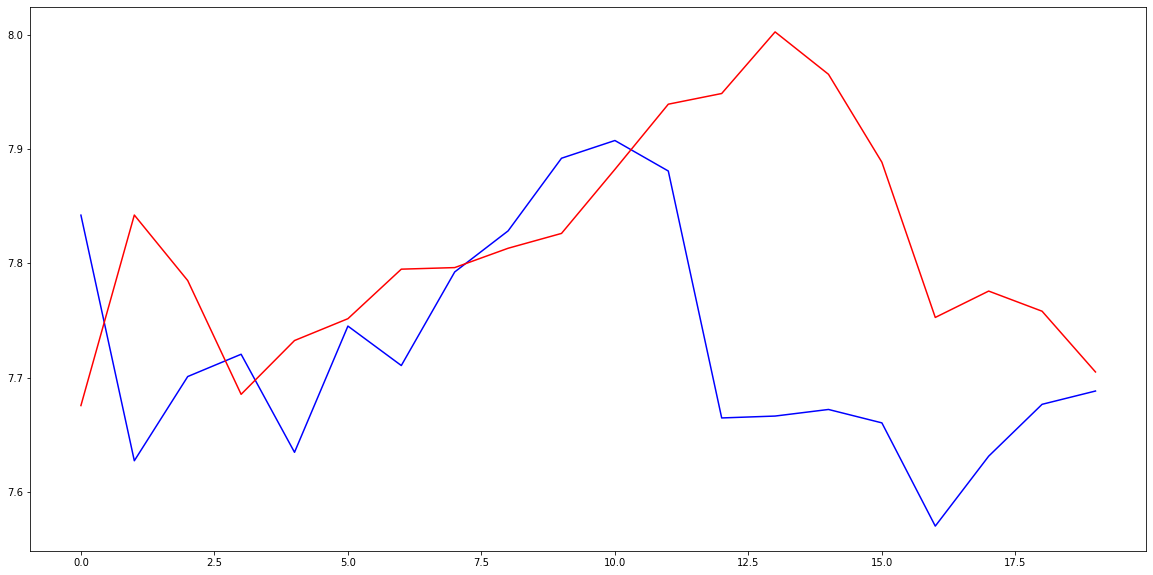

In [111]:
plt.figure(figsize = (20, 10))
plt.plot(np.mean(data_1, axis = 0), "b")
plt.plot(np.mean(data_2, axis = 0), "r")

In [ ]:
"""
which column performed the best?
"""

In [118]:
len(cols_trials)

20

In [122]:
if 0:
    print("ye")

In [115]:
len(results)

600

In [ ]:
results[]

In [123]:
results

[(12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),
 (12.174507732138485, 0.5, 11.272439934735488, 0.5, 14.46451302398196, 0.5),

In [124]:
598 / 19

31.473684210526315

In [138]:
col_indx= 0

In [139]:
(np.mean(results[col_indx], axis = 0)[-2] + np.mean(results[col_indx+1], axis = 0)[-2] )/ 2

14.731701207534172

In [148]:
parsed = {}
for _ in range(20):
    parsed[_] = 0


for num in range(15):
    
    for col_indx in range(0,40, 2):
        

         parsed[int(col_indx / 2)] += (np.mean(results[col_indx + (num * 40)], axis = 0)[-2] + np.mean(results[(col_indx) + (num * 40) + 1], axis = 0)[-2] )/ 2
        
    

In [162]:
with open("OptimisingTime/BinarylogVsSoftprob.pkl", "wb") as f:
    pickle.dump(results, f)

In [155]:
for i in parsed.keys():
    parsed[i] = parsed[i] / 15

In [157]:
cols_trials[3]

array(['Total Noncurrent Liabilities/Total Liabilities_QC',
       'Total Assets',
       'Cash from (Repayment of) Debt/Total Liabilities_YC',
       'close_80/Close_320', 'close_0/Close_320', 'CMO_120',
       'Total Noncurrent Liabilities/Total Liabilities', 'volstd_80',
       'Accounts & Notes Receivable/Revenue_YC',
       'Total Assets/Share Capital & Additional Paid-In Capital_YC',
       'volatility_120', 'close_240/Close_360', 'Total Liabilities_QC',
       'close_10/Close_40', 'Cash & Cash Equivalents/Total Liabilities',
       'Equity Before Minority Interest/Total Equity_YC',
       'BOL_indicator_120', 'WillR_20'], dtype=object)

In [158]:
cols_trials[6]

array(['close_40/Close_120', 'close_0/Close_40', 'close_0/Close_360',
       'ABAND_indicator_160', 'Cost of Revenue_YC', 'Current Ratio',
       'CMO_10', 'Total Noncurrent Liabilities/Total Liabilities',
       'Current Ratio_QC', 'AROON_120', 'BOL_indicator_120',
       'Return on Assets', 'close_120/Close_360',
       'Total Assets/Share Capital & Additional Paid-In Capital_YC',
       'EV/Sales_QC', 'close_0/Close_240', 'WillR_40',
       'close_160/Close_240'], dtype=object)

In [156]:
parsed

{0: 20.17442215404399,
 1: 25.597423189601304,
 2: 5.996437974958703,
 3: 107.41661235585859,
 4: 5.184349490936753,
 5: 12.906342676650564,
 6: 107.20175803893143,
 7: -1.7074113361461989,
 8: -3.8337881241527603,
 9: 12.463727861305241,
 10: 10.316916919412355,
 11: 20.11665666896953,
 12: 11.053606777892782,
 13: 12.980887901720624,
 14: 18.45565512344474,
 15: 19.12419635128246,
 16: 34.90264559768426,
 17: 30.17461727640889,
 18: 2.8433628502787553,
 19: 8.58949754808927}

In [149]:
col_indx

38

In [150]:
num

14

In [151]:
col_indx + 14*40 + 1

599

In [143]:
col_indx

38